In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.io import loadmat
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from mne.decoding import CSP

mne.set_log_level('WARNING')
import warnings
#warnings.filterwarnings("ignore") 

### Data Exploration with Participant 1 Data

Plotting Sensor Montage...


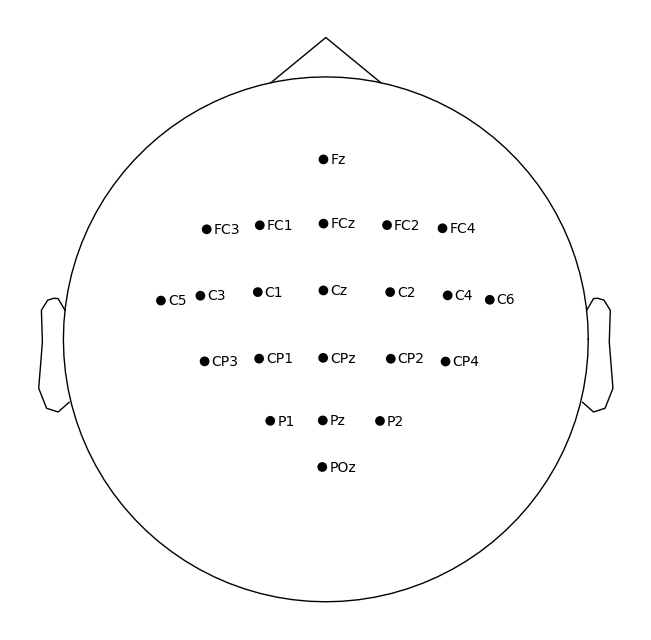

In [14]:
# Loading just participant 1's data first

p1 = loadmat('A01T.mat')

# The data is stored in a 1x9 list. I took the 4th item because that's usually the first Motor Imagery run.
run_data = p1['data'][0, 3] 

# Extracted the actual EEG signals (usually labeled 'X') and transposed it (.T) because MNE wants (Channels, Time)
eeg = run_data['X'][0, 0].T

# 4. Defined Channel Names; the first 22 are standard EEG positions
eeg_names = [
    'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 
    'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 
    'P2', 'POz'
]
# The last 3 are Eye movement (EOG) channels
eog_names = ['EOG1', 'EOG2', 'EOG3']
all_names = eeg_names + eog_names
ch_types = ['eeg'] * 22 + ['eog'] * 3

# Create the MNE Info Object
info = mne.create_info(ch_names=all_names, sfreq=250, ch_types=ch_types)
raw_preview = mne.io.RawArray(eeg, info)

# Set the standard 10-20 montage
# This tells MNE where each sensor (like 'C3') is physically located on the head
montage = mne.channels.make_standard_montage('standard_1020')
raw_preview.set_montage(montage)

raw_preview.plot_sensors(show_names=True, title="EEG Sensor Layout (10-20 System)");

### Machine Learning Pipeline

In [13]:
subjects = [f'A0{i}T.mat' for i in range(1, 10)]
accuracy_scores = []

print(f"{'Subject':<10} | {'Runs Loaded':<11} | {'Trials':<8} | {'Accuracy':<10} | {'Best Params'}")
print("-" * 85)

for subject_file in subjects:
    try:
        p_data = loadmat(subject_file)
        combined_data = []
        combined_events = []
        
        max_runs = p_data['data'].shape[1]
        runs_found = 0
        
        # Loop through potential motor imagery runs
        for i in [3, 4, 5, 6, 7, 8]:
            if i < max_runs:
                run_data = p_data['data'][0, i]
                if run_data['X'].size > 0:
                    eeg = run_data['X'][0, 0].T
                    trial_starts = run_data['trial'][0, 0].flatten()
                    trial_labels = run_data['y'][0, 0].flatten()
                    
                    if len(combined_data) > 0:
                        offset = sum([d.shape[1] for d in combined_data])
                        trial_starts += offset
                    
                    events = np.vstack([trial_starts, np.zeros_like(trial_starts), trial_labels]).T.astype(int)
                    combined_data.append(eeg)
                    combined_events.append(events)
                    runs_found += 1

        final_data = np.hstack(combined_data)
        final_events = np.vstack(combined_events) 
        info = mne.create_info(ch_names=all_names, sfreq=250, ch_types=ch_types)
        raw_full = mne.io.RawArray(final_data, info)
        raw_full.set_montage(mne.channels.make_standard_montage('standard_1020'))
        
        # Using 7-30Hz as it covers both Mu (8-12) and Beta (13-30)
        raw_full.filter(7., 30., verbose=False)
        
        event_id = {'Left': 1, 'Right': 2}
        epochs = mne.Epochs(raw_full, final_events, event_id, tmin=0, tmax=4.0, 
                            proj=True, baseline=None, preload=True, verbose=False)
        
        epochs.pick_channels(eeg_names)

        # --- MACHINE LEARNING (GridSearch) ---
        X = epochs.get_data()
        y = epochs.events[:, -1]
        
        if len(y) > 10:
            pipeline = Pipeline([
                ('Covariances', Covariances(estimator='oas')),
                ('TangentSpace', TangentSpace()),
                ('Classifier', LogisticRegression(solver='liblinear', max_iter=1000))
            ])
            
            param_grid = {
                'Classifier__C': [0.1, 0.5, 1.0, 5.0, 10.0],  
                'Classifier__penalty': ['l1', 'l2']           
            }
        
            cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
            grid = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)
            grid.fit(X, y)
            
            best_acc = grid.best_score_
            best_params = str(grid.best_params_)
            
            accuracy_scores.append(best_acc)
            
            simple_params = best_params.replace("Classifier__", "").replace("penalty", "pen")
            print(f"{subject_file:<10} | {runs_found:<11} | {len(y):<8} | {best_acc:.2%} | {simple_params}")
        else:
            print(f"{subject_file:<10} | {runs_found:<11} | LOW DATA | N/A")
            
    except Exception as e:
        print(f"{subject_file:<10} | Error: {e}")

print("-" * 85)
if len(accuracy_scores) > 0:
    print(f"AVERAGE    |             |          | {np.mean(accuracy_scores):.2%}")

Subject    | Runs Loaded | Trials   | Accuracy   | Best Params
-------------------------------------------------------------------------------------
A01T.mat   | 6           | 144      | 64.14% | {'C': 1.0, 'pen': 'l1'}
A02T.mat   | 6           | 144      | 66.90% | {'C': 5.0, 'pen': 'l1'}
A03T.mat   | 6           | 144      | 73.79% | {'C': 5.0, 'pen': 'l2'}
A04T.mat   | 4           | 96       | 59.00% | {'C': 10.0, 'pen': 'l2'}
A05T.mat   | 6           | 144      | 55.86% | {'C': 0.5, 'pen': 'l1'}
A06T.mat   | 6           | 144      | 60.69% | {'C': 10.0, 'pen': 'l2'}
A07T.mat   | 6           | 144      | 62.07% | {'C': 0.5, 'pen': 'l1'}
A08T.mat   | 6           | 144      | 88.28% | {'C': 1.0, 'pen': 'l1'}
A09T.mat   | 6           | 144      | 81.38% | {'C': 0.5, 'pen': 'l2'}
-------------------------------------------------------------------------------------
AVERAGE    |             |          | 68.01%


### Heatmap Comparison

In [ ]:
comparison_subjects = ['A08T.mat', 'A05T.mat']
titles = ['Most Accurate (A08T)', 'Least Accurate (A05T)']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Why Accuracy Varies: Clear vs. Noisy Motor Cortex Signals", fontsize=20)

for idx, subject_file in enumerate(comparison_subjects):
    p_data = loadmat(subject_file)
    combined_data, combined_events = [], []
    
    for i in [3, 4, 5, 6, 7, 8]:
        if i < p_data['data'].shape[1] and p_data['data'][0, i]['X'].size > 0:
            eeg = p_data['data'][0, i]['X'][0, 0].T
            trial_starts = p_data['data'][0, i]['trial'][0, 0].flatten()
            trial_labels = p_data['data'][0, i]['y'][0, 0].flatten()
            if len(combined_data) > 0: 
                trial_starts += sum([d.shape[1] for d in combined_data])
            events = np.vstack([trial_starts, np.zeros_like(trial_starts), trial_labels]).T.astype(int)
            combined_data.append(eeg)
            combined_events.append(events)

    final_data = np.hstack(combined_data)
    info = mne.create_info(ch_names=all_names, sfreq=250, ch_types=ch_types)
    raw = mne.io.RawArray(final_data, info)
    raw.set_montage(mne.channels.make_standard_montage('standard_1020'))
    raw.filter(7., 30., verbose=False)
    
    epochs = mne.Epochs(raw, np.vstack(combined_events), event_id, 
                        tmin=0.5, tmax=3.5, proj=True, baseline=None, preload=True, verbose=False)
    epochs.pick_channels(eeg_names)
    
    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
    csp.fit(epochs.get_data(), epochs.events[:, -1])
        
    axes[idx, 0].set_ylabel(titles[idx], fontsize=16, fontweight='bold')
    
    for comp_i in range(4):
        pattern_data = csp.patterns_[comp_i]
        
        mne.viz.plot_topomap(
            pattern_data, 
            epochs.info, 
            axes=axes[idx, comp_i], 
            show=False,
            cmap='RdBu_r'
        )
        
        axes[idx, comp_i].set_title(f"CSP {comp_i}", fontsize=12)

plt.tight_layout()
plt.show()